<a href="https://colab.research.google.com/github/vinayp1120/Violence_detection_1/blob/main/Inception_ResNetViolence_detection_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Objective***:  Classify videos into violent or non-violent categories.
***Dataset***:  Obtained a labeled dataset of violent and non-violent videos.Each video is labeled with either "violent" or "non-violent".
***Preprocessing***:  Each video will be split into frames, then processed as sequences of frames.
Got Dataset from the Kaggle

In [1]:
!pip install kaggle

In [2]:
!pip install tensorflow

In [3]:
'''!kaggle datasets download -d karandeep98/real-life-violence-and-nonviolence-data
!unzip real-life-violence-and-nonviolence-data.zip'''


'!kaggle datasets download -d karandeep98/real-life-violence-and-nonviolence-data\n!unzip real-life-violence-and-nonviolence-data.zip'

In [4]:
'''!cd /content/violence_dataset
!mv violence_dataset /content/drive/MyDrive/kaggle_violence'''

'!cd /content/violence_dataset\n!mv violence_dataset /content/drive/MyDrive/kaggle_violence'

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [6]:
# Directory where your dataset is stored
data_dir = '/content/drive/MyDrive/kaggle_violence/violence_dataset'
categories = ['violence', 'non_violence']

# Image dimensions
img_height = 224
img_width = 224


In [15]:
# Load dataset using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=categories,
    subset='training'  # Use subset='training' for training data
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=categories,
    subset='validation'  # Use subset='validation' for validation data
)


Found 5481 images belonging to 2 classes.
Found 1370 images belonging to 2 classes.


Architecture 2: Inception-ResNet

In [16]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def build_inception_resnet_model(input_shape):
    # Load the InceptionResNetV2 model pre-trained on ImageNet (without fully connected layers)
    inception_resnet_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze InceptionResNetV2 layers to prevent retraining
    for layer in inception_resnet_base.layers:
        layer.trainable = False

    # Functional API model
    inputs = tf.keras.Input(shape=input_shape)
    x = inception_resnet_base(inputs, training=False)  # Apply InceptionResNetV2 base
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [17]:
# Input shape: (height, width, channels)
input_shape = (img_height, img_width, 3)  # 3 channels (RGB)

# Build and compile the model
model = build_inception_resnet_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 38400)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               4915328   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                           

In [18]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)

Epoch 1/10
171/171 [==============================] - 768s 4s/step - loss: 0.6146 - accuracy: 0.9005 - val_loss: 0.2317 - val_accuracy: 0.8876
Epoch 2/10
171/171 [==============================] - 48s 282ms/step - loss: 0.1093 - accuracy: 0.9543 - val_loss: 0.1366 - val_accuracy: 0.9531
Epoch 3/10
171/171 [==============================] - 47s 273ms/step - loss: 0.0738 - accuracy: 0.9725 - val_loss: 0.2146 - val_accuracy: 0.9182
Epoch 4/10
171/171 [==============================] - 49s 284ms/step - loss: 0.0745 - accuracy: 0.9706 - val_loss: 0.1476 - val_accuracy: 0.9464
Epoch 5/10
171/171 [==============================] - 48s 278ms/step - loss: 0.0452 - accuracy: 0.9809 - val_loss: 0.1780 - val_accuracy: 0.9457
Epoch 6/10
171/171 [==============================] - 48s 277ms/step - loss: 0.0319 - accuracy: 0.9868 - val_loss: 0.1382 - val_accuracy: 0.9583
Epoch 7/10
171/171 [==============================] - 46s 271ms/step - loss: 0.0286 - accuracy: 0.9881 - val_loss: 0.1277 - val_accu

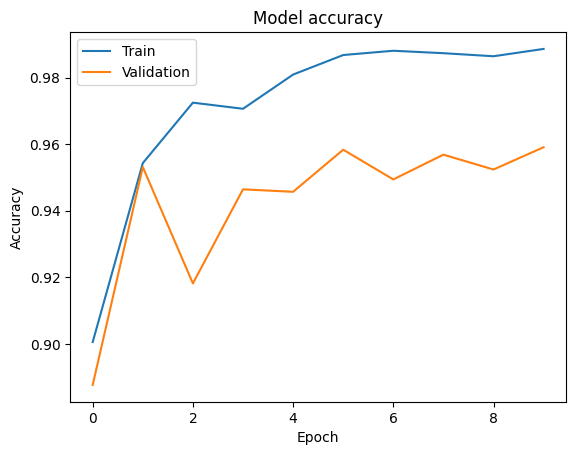

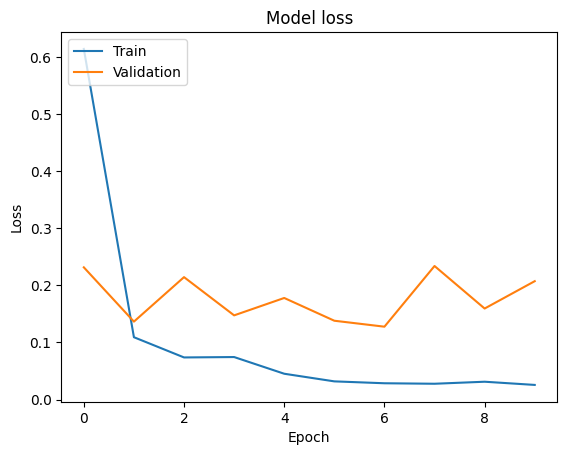

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [20]:
# Save the model in .h5 format
model.save('/content/drive/MyDrive/kaggle_violence/vgg16_violence_detection_Inception-ResNet.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/kaggle_violence/vgg16_violence_detection_Inception-ResNet.h5')


In [23]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


43/43 [==============================] - 16s 285ms/step - loss: 0.2146 - accuracy: 0.9584
Validation Loss: 0.21462273597717285
Validation Accuracy: 0.9583941698074341
